In [ ]:
%pip install nltk
%pip install pandas
%pip install scikit-learn
%pip install -U imbalanced-learn
%pip install gensim
%pip install kaggle
%pip install matplotlib
%pip install seaborn

### Using Kaggle's api to download the dataset

In [ ]:
import re
import os
import zipfile

os.system('kaggle datasets download -d paakhim10/tweets-and-engagement-metrics')
with zipfile.ZipFile('tweets-and-engagement-metrics.zip', 'r') as zip_ref:
    zip_ref.extractall('')


### Reading the dataset into pandas frame

In [12]:
import pandas as pd

tweets_df = pd.read_csv("tweets-engagement-metrics.csv")


## Preprocessing the dataset

### a) Converting to lowercase, basic tokenization , punctuation and number removing

In [13]:
import re
def simple_preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuations and numbers
    text = re.sub(r'[^\w\s]', '', text)  # Removes punctuation
    text = re.sub(r'\d+', '', text)      # Removes numbers

    # Basic tokenization (splitting text into words)
    tokens = text.split()

    return ' '.join(tokens)

tweets_df = tweets_df[tweets_df['Lang'] == 'en'] #removing all rows with non-english text
tweets_df['processed_text'] = tweets_df['text'].apply(simple_preprocess_text)
tweets_df[['text', 'processed_text']].head()


,text,processed_text
0,"""RT @AdrianRusso82: Our Innovation Lab is offi...",rt adrianrusso our innovation lab is officiall...
1,Now Open AWS Asia Pacific (Seoul) Region via ...,now open aws asia pacific seoul region via rsy...
2,A Beginner's Guide to Scaling to 11 Million+ U...,a beginners guide to scaling to million users ...
3,Bridging AWS and Azure environments via VPN vi...,bridging aws and azure environments via vpn vi...
4,ELK on AWS ElasticSearch Service + ElasticBean...,elk on aws elasticsearch service elasticbeanst...


### b)  Further preprocessing using nltk ( remove emojis,stop words removal and stemming)

[nltk_data] Downloading package punkt to C:\Users\Omer
[nltk_data]     Habib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Omer
[nltk_data]     Habib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text  \
0  "RT @AdrianRusso82: Our Innovation Lab is offi...   
1  Now Open  AWS Asia Pacific (Seoul) Region via ...   
2  A Beginner's Guide to Scaling to 11 Million+ U...   
3  Bridging AWS and Azure environments via VPN vi...   
4  ELK on AWS ElasticSearch Service + ElasticBean...   

                                      processed_text  
0  rt our innov lab offici open click learn tech ...  
1  now open aw asia pacif seoul region via rsysadmin  
2  a beginn guid scale 11 million user amazon aw ...  
3        bridg aw azur environ via vpn via rsysadmin  
4  elk aw elasticsearch servic elasticbeanstalk l...  


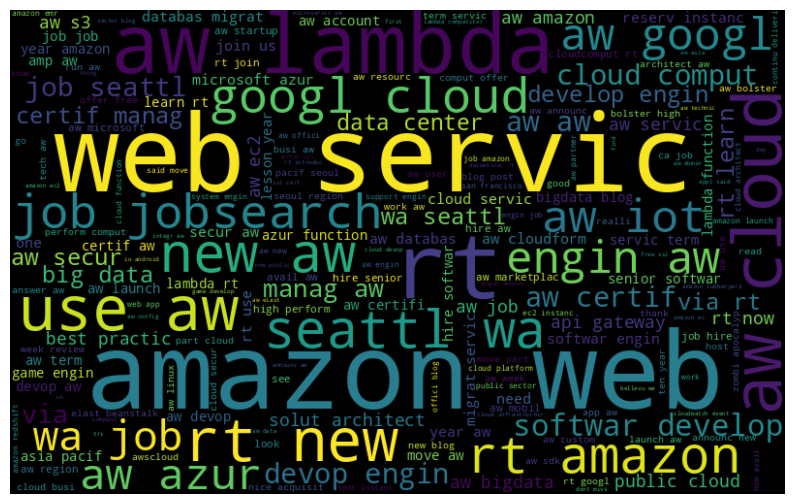

In [14]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Downloading NLTK data
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove usernames
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Join the tokens back into a string
    return ' '.join(tokens)


tweets_df['processed_text'] = tweets_df['text'].apply(preprocess_text)
print(tweets_df[['text', 'processed_text']].head())


all_words = ' '.join([text for text in tweets_df['processed_text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


## Label dataset using VADER


In [15]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    # getting the polarity scores from VADER
    return sia.polarity_scores(text)

tweets_df['sentiment'] = tweets_df['processed_text'].apply(get_sentiment)
tweets_df[['text', 'processed_text', 'sentiment']].head()
tweets_df[['text', 'processed_text', 'sentiment']].to_csv("check.csv")

[nltk_data] Downloading package vader_lexicon to C:\Users\Omer
[nltk_data]     Habib\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Analysing the dataset for further training

In [16]:
%pip install matplotlib 
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Sentiment distribution:
sentiment_category
neutral     46037
positive    40180
negative     7347
Name: count, dtype: int64
The dataset is not approximately balanced.


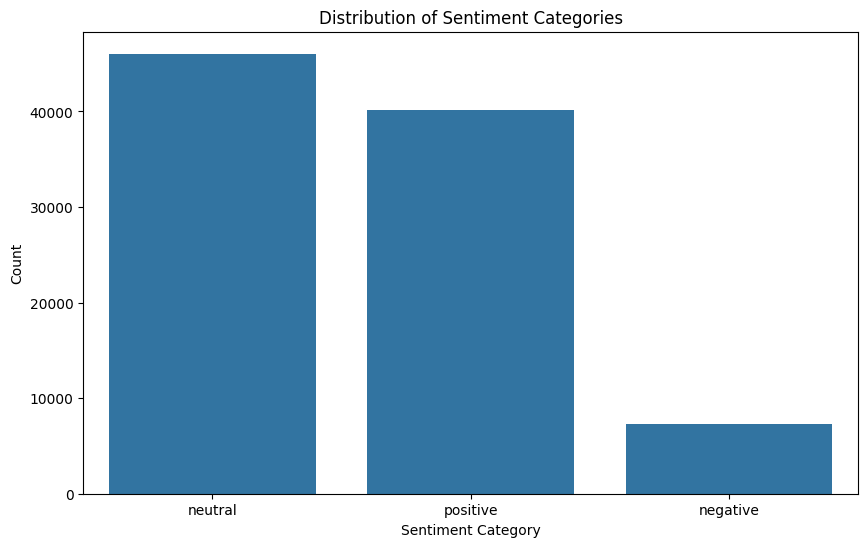

In [17]:
import matplotlib.pyplot as plt
import  seaborn as sns

# Extracting the compound score in a new column
tweets_df['compound'] = tweets_df['sentiment'].apply(lambda x: x['compound'] if isinstance(x, dict) else None)

# Classifying the sentiments
def categorize_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

tweets_df['sentiment_category'] = tweets_df['compound'].apply(categorize_sentiment)
sentiment_distribution = tweets_df['sentiment_category'].value_counts() # checking the distribution of sentiment categories

# Checking if dataset is balanced
is_balanced = sentiment_distribution.min() / sentiment_distribution.max()

print("Sentiment distribution:")
print(sentiment_distribution)
print(f"The dataset {'is' if is_balanced > 0.5 else 'is not'} approximately balanced.")



##                                                 Feature Extraction

### a)Balancing the dataset and using TD_IDF for preparing the model

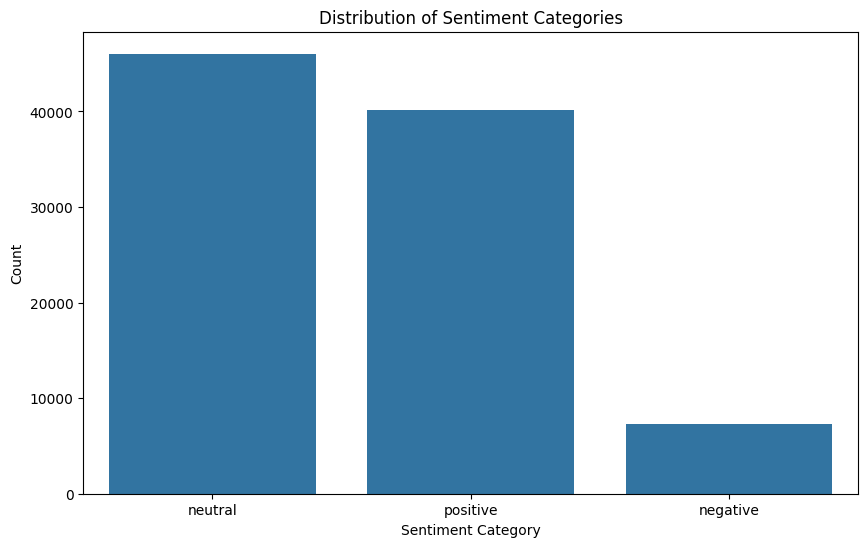

Distribution of classes in oversampled training set: Counter({'positive': 32225, 'neutral': 32225, 'negative': 32225})


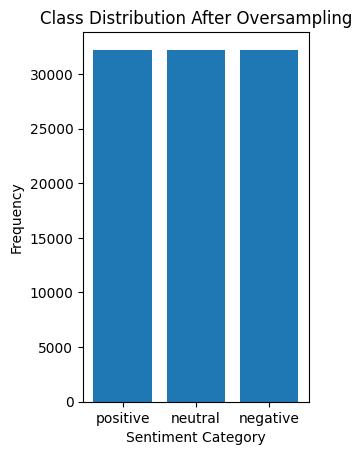

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


#distribution before sampling
sentiment_counts = tweets_df['sentiment_category'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

# Feature Extraction: Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=10000) 
X = tfidf_vectorizer.fit_transform(tweets_df['processed_text'])

y = tweets_df['sentiment_category']

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

#  Over-sampler
ros = RandomOverSampler(random_state=42)

# Apply the over-sampler to the training data
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Check the distribution of the oversampled training data
distribution_ros = Counter(y_train_ros)
print("Distribution of classes in oversampled training set:", distribution_ros)


# Distribution after oversampling
plt.subplot(1, 2, 2)
plt.bar(distribution_ros.keys(), distribution_ros.values())
plt.title('Class Distribution After Oversampling')
plt.xlabel('Sentiment Category')
plt.ylabel('Frequency')
plt.show()


### b) Word2Vec Feature Extraction for model

In [19]:
from gensim.models import Word2Vec
import numpy as np

# Tokenize the text
tweets_df['tokenized'] = tweets_df['processed_text'].apply(lambda x: x.split())

# Train  Word2Vec model
word2vec_model = Word2Vec(sentences=tweets_df['tokenized'], vector_size=100, window=5, min_count=1, workers=4)

# function to vectorize a text using Word2Vec
def vectorize_text(text, model):
    vector = np.mean([model.wv[word] for word in text if word in model.wv] or [np.zeros(100)], axis=0)
    return vector


X_word2vec = np.array([vectorize_text(text, word2vec_model) for text in tweets_df['tokenized']])


In [20]:
from sklearn.manifold import TSNE

# Select top N words
top_words = 100
vocab = list(word2vec_model.wv.key_to_index)[:top_words]
embeddings = [word2vec_model.wv[word] for word in vocab]

# Use t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(12, 12))
for i, word in enumerate(vocab):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.title('Word2Vec Word Embeddings Visualized with t-SNE')
plt.show()


AttributeError: 'list' object has no attribute 'shape'

## Naives Bayes Model

### ML Model by combining TD_IDF and Word2Vec

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from gensim.models import Word2Vec
import numpy as np
from scipy.sparse import hstack, csr_matrix

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(tweets_df['processed_text'])

# Word2Vec Feature Extraction
tweets_df['tokenized'] = tweets_df['processed_text'].apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences=tweets_df['tokenized'], vector_size=50, window=5, min_count=1, workers=4)

def vectorize_text(text, model):
    return np.mean([model.wv[word] for word in text if word in model.wv] or [np.zeros(50)], axis=0)

# Handling ValueError in Word2Vec vectorization
try:
    X_word2vec = np.array([vectorize_text(text, word2vec_model) for text in tweets_df['tokenized']])
except ValueError as e:
    print("Error occurred:", e)
    

# Scale Word2Vec features
scaler = StandardScaler()
X_word2vec_scaled = scaler.fit_transform(X_word2vec)

#  Word2Vec features to be non-negative
min_feature_value = X_word2vec_scaled.min()
if min_feature_value < 0:
    X_word2vec_scaled += abs(min_feature_value)
X_word2vec_sparse = csr_matrix(X_word2vec_scaled)

# Combine TF-IDF and Word2Vec features
X_combined = hstack([X_tfidf, X_word2vec_sparse])

# Splitting the data
y = tweets_df['sentiment_category']
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_combined, y, test_size=0.3, random_state=42, stratify=y
)

# Oversampling
ros = RandomOverSampler(random_state=42)
X_train_combined_ros, y_train_combined_ros = ros.fit_resample(X_train_combined, y_train_combined)

# Naive Bayes Model
nb_classifier = ComplementNB()
nb_classifier.fit(X_train_combined_ros, y_train_combined_ros)
y_pred_combined = nb_classifier.predict(X_test_combined)

print(classification_report(y_test_combined, y_pred_combined))


              precision    recall  f1-score   support

    negative       0.41      0.93      0.57      2204
     neutral       0.88      0.76      0.82     13812
    positive       0.87      0.81      0.84     12054

    accuracy                           0.80     28070
   macro avg       0.72      0.83      0.74     28070
weighted avg       0.84      0.80      0.81     28070


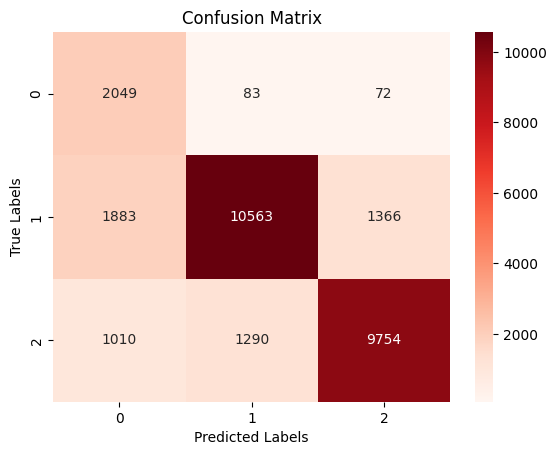

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'y_test_combined' is your test labels and 'y_pred_combined' are your predictions
cm = confusion_matrix(y_test_combined, y_pred_combined)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
